In [2]:
#Run to analyze drivers of Palisades and Eaton Fires
from getancillary.getShape import getShape
from getancillary.DataReader import read_ecostress
from getancillary.getGridMet import downloadGridMet, GridMet_cropped
from regrid.regridinputs import regridinputs, regridinputs2, regridinputs3
from getancillary.getNDVI import downloadNDVI, NDVI_cropped
from getancillary.getDNBR import getDNBR
from getancillary.getDEM import getDEM
from getancillary.getDEM import getDEM, CroppedDEM

from randomforest.RandomForestRegression import RandomForestRegression


# import richdem as rd
import requests
import geopandas as gpd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import os


import os
# import folium
import earthaccess
import warnings
# import folium.plugins
import pandas as pd
import geopandas as gpd
import math

from shapely import geometry
import xarray

In [3]:
#Fire
fire_name = 'palisades'


#Year, Month, Day
yyyy = 2025
mm = 1
dd = 7

#Set path to data sets
path_to_data = '/Users/madeleip/Documents/PROJECTS/ECOSTRESS_Fires_2025/data/'

#Load the shapefile
path_to_shape = path_to_data + 'shape_files/' + fire_name

In [4]:
#Load the shapefile

shape = getShape(path_to_shape)

In [5]:
from getecostress.getECO import getECO, getECO_cropped
#Check if file exists or download the tiled file
eco_file = getECO(path_to_shape, path_to_data, yyyy, mm, dd)

ET = getECO_cropped(eco_file, path_to_shape)

5 granules total
1 granule total (largest)  
ECOv002_L3T_JET_36568_010_11SLT_20241217T202408_0713_01_ETdaily.tif'
["ECOv002_L3T_JET_36568_010_11SLT_20241217T202408_0713_01_ETdaily.tif'", '.DS_Store', "ECOv002_L3T_JET_36629_011_11SLU_20241221T184414_0713_01_ETdaily.tif'"]
File exists already!


In [6]:
#Load the ET data (Manual download from Appears)
# path_to_et = path_to_data + fire_name + '/ET'
# ET = read_ecostress(path_to_et)        

In [7]:
#download windspeed for particular year, month, day  
variable = 'vs'
ws = downloadGridMet(yyyy, mm, dd,variable)
ws = GridMet_cropped(ws, 'wind_speed',path_to_shape)

2025-01-07
downloading from server...


In [8]:
#download windspeed for particular year, month, day  
variable = 'vpd'
vpd = downloadGridMet(yyyy, mm, dd,variable)
vpd = GridMet_cropped(vpd, 'mean_vapor_pressure_deficit',path_to_shape)

2025-01-07
downloading from server...


In [9]:
#download windspeed for particular year, month, day  
variable = 'tmmx'
tmmx = downloadGridMet(yyyy, mm, dd,variable)
tmmx = GridMet_cropped(tmmx, 'air_temperature',path_to_shape)

2025-01-07
downloading from server...


In [10]:

# = GET RID of EVENTUALLY =
#read in dNBR

path_to_dnbr = path_to_data + 'dnbr/Eaton_Palisade_Single_Band_dNBR/' + fire_name 
dnbr, dnbr_lon, dnbr_lat = getDNBR(path_to_dnbr, shape)
#  dnbr = dnbr[1,::,::]

/Users/madeleip/Documents/PROJECTS/ECOSTRESS_Fires_2025/data/dnbr/Eaton_Palisade_Single_Band_dNBR/palisades/dNBR_palisades_1Y_SB.tif


/Users/madeleip/Documents/PROJECTS/ECOSTRESS_Fires_2025/code/getancillary/getDNBR.py:61: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, longs = transform(p1, p2, eastings, northings)


In [11]:
#Get DEM 
getDEM(path_to_shape, path_to_data + '/dem/' + fire_name)
dem, dem_lat, dem_lon = CroppedDEM(path_to_data + '/dem/' +fire_name, shape)

Failed to download data: 500
DEM exists


/Users/madeleip/Documents/PROJECTS/ECOSTRESS_Fires_2025/code/getancillary/getDEM.py:104: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, longs = transform(p1, p2, eastings, northings)


In [12]:
# #NDVI 
# ndvi = downloadNDVI(yyyy)
# ndvi = NDVI_cropped(ndvi, 'NDVI',path_to_shape)


In [13]:
dnbr.shape

(371, 689)

In [14]:
#Regrid all to same grid
tmmx_regrid = regridinputs(np.array(ET.lon), np.array(ET.lat), np.array(tmmx[0].lon), np.array(tmmx[0].lat), np.squeeze(np.array(tmmx[0])))
vpd_regrid = regridinputs(np.array(ET.lon), np.array(ET.lat), np.array(vpd[0].lon), np.array(vpd[0].lat), np.squeeze(np.array(vpd[0])))
ws_regrid = regridinputs(np.array(ET.lon), np.array(ET.lat), np.array(ws[0].lon), np.array(ws[0].lat), np.squeeze(np.array(ws[0])))
# ndvi_regrid = regridinputs(np.array(ET.lon), np.array(ET.lat), np.array(ndvi[0].longitude), np.array(ndvi[0].latitude), np.squeeze(np.array(ndvi[0])))
dnbr_regrid = regridinputs2(np.array(ET.lon), np.array(ET.lat), np.array(dnbr_lon), np.array(dnbr_lat), np.squeeze(np.array(dnbr)))
dem_regrid = regridinputs2(np.array(ET.lon), np.array(ET.lat), np.array(dem_lon), np.array(dem_lat), np.squeeze(np.array(dem)))


(143, 266)
(371, 689)
(143, 266)
(358, 668)


In [15]:
# #Mask
mask = np.where(dnbr_regrid == 0, np.nan, dnbr_regrid) #mask out regions outside fire mask
mask = np.where(mask > 0, 1, np.nan) #mask out regions outside fire mask

# plt.pcolor(mask);plt.colorbar()

In [16]:
#mask the other regions
dnbr_regrid = dnbr_regrid * mask
tmmx_regrid = tmmx_regrid * mask
vpd_regrid = vpd_regrid * mask
ws_regrid = ws_regrid * mask
et_regrid = np.asarray(ET * mask)
dem_regrid = dem_regrid * mask

#Get Coords
lon = np.array(ET['lon']) 
lat = np.array(ET['lat']) 

(lon,lat) = np.meshgrid(lon, lat, copy = False)
lon = lon * mask
lat = lat * mask

In [17]:
# Calculate the slope and aspect 
x, y = np.gradient(dem_regrid) 
slope = np.sqrt(x**2 + y**2) 
aspect = np.arctan2(-x, y)
aspect = np.degrees(aspect) 
aspect = np.where(aspect < 0, 360 + aspect, aspect)

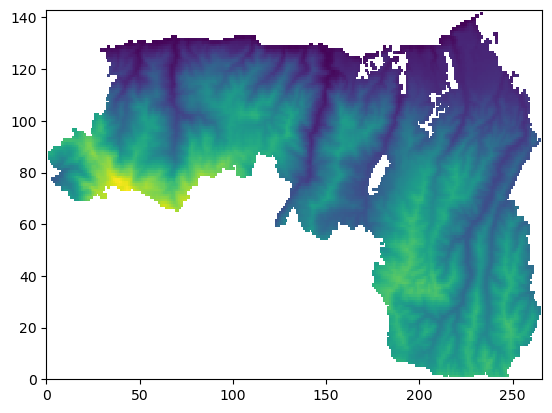

In [18]:
plt.pcolor(dem_regrid)

In [19]:
dnbr_regrid.ravel()

array([nan, nan, nan, ..., nan, nan, nan])

In [20]:
#create a pandas dataframe containing all the parameters

import pandas as pd

features = np.squeeze(np.dstack((dnbr_regrid.ravel(),
                      et_regrid.ravel(), 
                      tmmx_regrid.ravel(), 
                      vpd_regrid.ravel(),
                      ws_regrid.ravel(),
                      dem_regrid.ravel(),
                      slope.ravel(),
                      aspect.ravel(),
                      lon.ravel(),
                      lat.ravel()
                      )))



df = pd.DataFrame(features, columns=["dNBR",
                                        "ET",
                                        "TMMX",
                                        "VPD",
                                        "WS",
                                        "Elevation",
                                        "Slope",
                                        "Aspect",
                                        "X",
                                        "Y"])

In [21]:
df.head()

,dNBR,ET,TMMX,VPD,WS,Elevation,Slope,Aspect,X,Y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


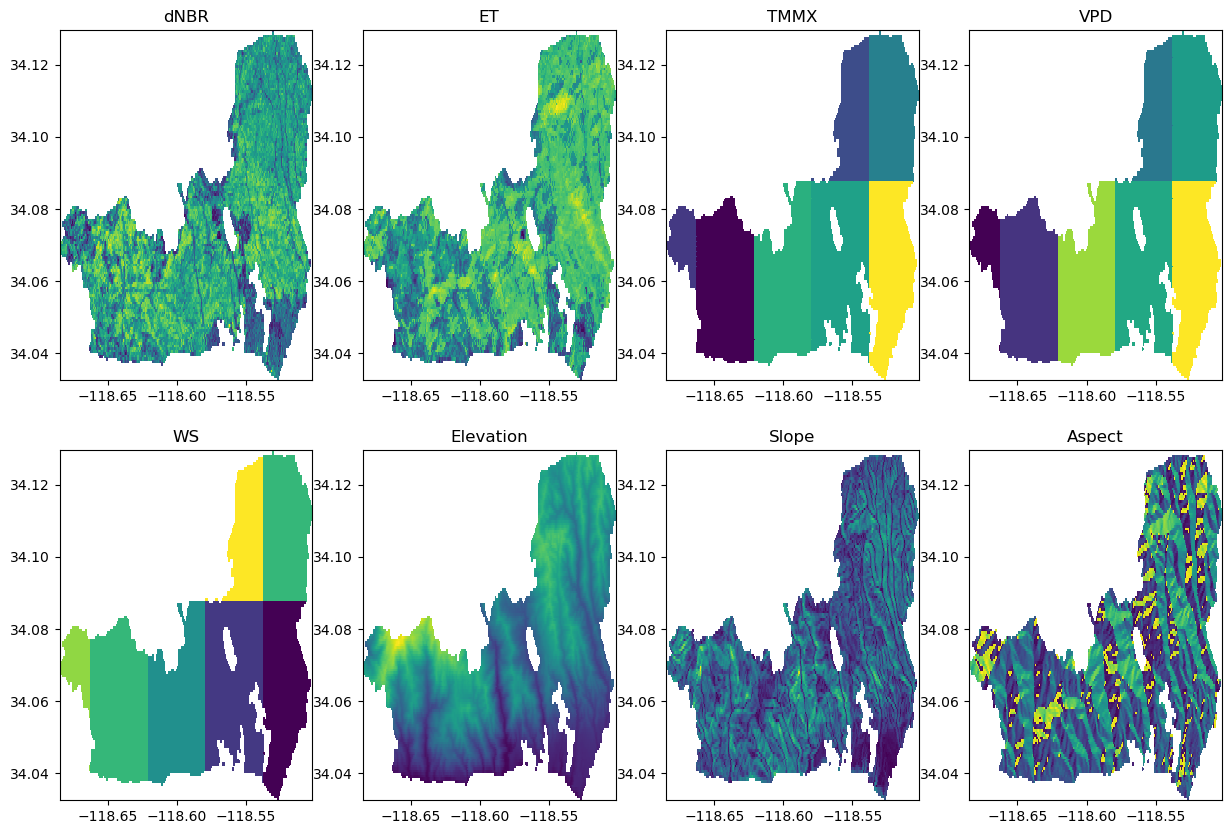

In [22]:
#Plot All Predictors
column_names = df.columns

# Create a 3 by 4 subplot figure 
fig, axes = plt.subplots(2, 4, figsize=(15, 10)) 
# Loop through each subplot and plot the data 
k = 0
for i in range(2): 
    for j in range(4): 
        axes[i, j].pcolor(lon,lat,np.reshape(features[::,k],(dnbr_regrid.shape)))
        axes[i, j].set_title(column_names[k])
        k = k + 1



In [23]:
#Load Model From 'All Fires'
# import joblib

# path_to_model = '/Users/madeleip/Documents/PROJECTS/ECOSTRESS_Fire_Risk_All_Fires/data/model_runs/'

# # Load the model from the file 
# loaded_model = joblib.load(path_to_model + 'random_forest_model.pkl')

In [24]:
# from randomforest.RandomForestRegression import ApplyRandomForestRegression


# #training percentage 
# N_train = 0.5

# #Simple RF Model run using 'best_params' found above with GridSearchCV
# R2, mse,Weights,labels,X_train, X_test, y_train, y_test,y_pred,ypredlon,ypredlat,rf  = ApplyRandomForestRegression(df,N_train, 1 - N_train, fire_name,loaded_model)



In [25]:
#Split data into Training, Validation, Test Data
from randomforest.RandomForestRegression import RandomForestDataSplit
X_train, X_test, X_val, y_train, y_test, y_val = RandomForestDataSplit(df)

#Store Lat Lon Coords
lat_test = X_test[:,8]
lon_test = X_test[:,7]

lat_train = X_train[:,8]
lon_train = X_train[:,7]


38038
19019.0


In [ ]:

#Train RF Model Initially
from randomforest.RandomForestRegression import RandomForestTrain
model = RandomForestTrain(features, X_train, X_test, X_val, y_train, y_test, y_val)

#Tune data using Validation Set
from randomforest.RandomForestRegression import RandomForestValTune
best_params = RandomForestValTune(X_val, y_val, model)



In [ ]:
#Combine train + validation and test best model 
from randomforest.RandomForestRegression import RandomForestBestModel
y_test_pred, X_test = RandomForestBestModel(X_train, X_test, X_val, y_train, y_test, y_val, best_params)




combine datas val and train
running model with best params...
Val Set R-2 score: 0.321
Val Set MSE: 0.0139


0.321077494065535

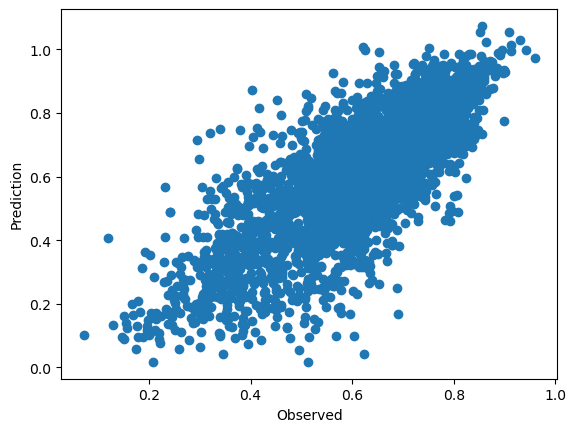

In [38]:
plt.scatter(y_test_pred, y_test)
plt.xlabel('Observed')
plt.ylabel('Prediction')
from sklearn.metrics import r2_score
r2_score(y_test_pred, y_test)

In [39]:
import scipy

pred = scipy.interpolate.griddata((lon_test.ravel(),lat_test.ravel()),y_test_pred.ravel(),(lon.ravel(),lat.ravel()),'linear');
obs = scipy.interpolate.griddata((lon_test.ravel(),lat_test.ravel()),y_test.ravel(),(lon.ravel(),lat.ravel()),'linear');


/var/folders/d3/z1z58w8d03g3pjktk48j690w0000gq/T/ipykernel_44759/812149270.py:1: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.pcolor(lon,lat,np.reshape(pred,(lon.shape)),vmin = 0, vmax = 1, cmap = 'magma');plt.colorbar();plt.title('Predicted dNBR');plt.show()


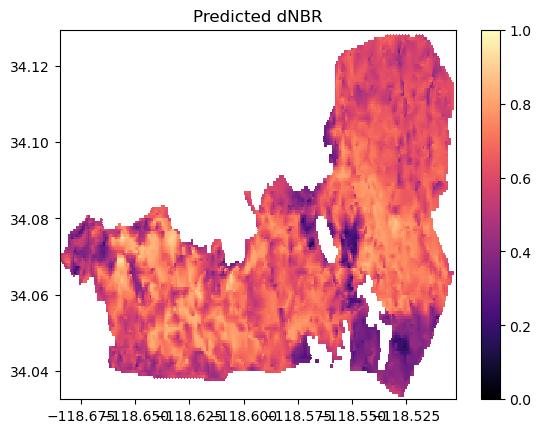

/var/folders/d3/z1z58w8d03g3pjktk48j690w0000gq/T/ipykernel_44759/812149270.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.pcolor(lon,lat,np.reshape(obs,(lon.shape)),vmin = 0, vmax = 1, cmap = 'magma');plt.title('Observed dNBR');plt.colorbar();plt.show()


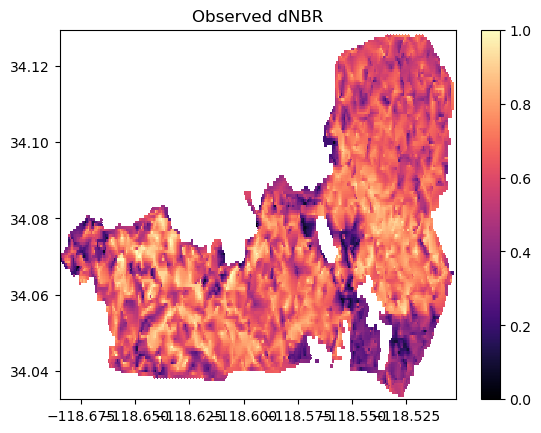

/var/folders/d3/z1z58w8d03g3pjktk48j690w0000gq/T/ipykernel_44759/812149270.py:3: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.pcolor(lon,lat,np.reshape(pred,(lon.shape)) - np.reshape(obs,(lon.shape)),vmin = -1, vmax = 1, cmap = 'coolwarm');plt.title('Predicted - Observed dNBR');plt.colorbar()


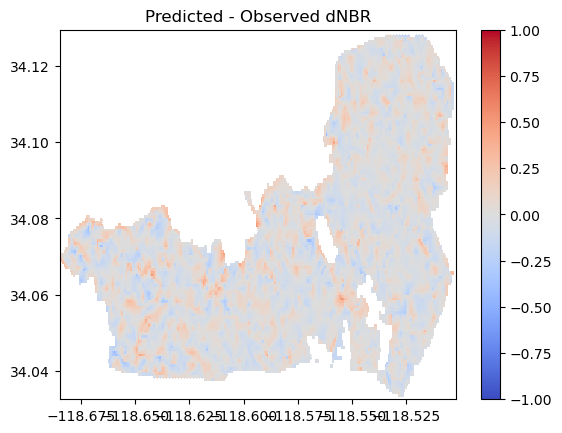

In [40]:
plt.pcolor(lon,lat,np.reshape(pred,(lon.shape)),vmin = 0, vmax = 1, cmap = 'magma');plt.colorbar();plt.title('Predicted dNBR');plt.show()
plt.pcolor(lon,lat,np.reshape(obs,(lon.shape)),vmin = 0, vmax = 1, cmap = 'magma');plt.title('Observed dNBR');plt.colorbar();plt.show()
plt.pcolor(lon,lat,np.reshape(pred,(lon.shape)) - np.reshape(obs,(lon.shape)),vmin = -1, vmax = 1, cmap = 'coolwarm');plt.title('Predicted - Observed dNBR');plt.colorbar()

In [ ]:
# from randomforest.RandomForestRegression import RandomForestInit

# N_train = 0.8 # training percentage 
# best_params = RandomForestInit(df, N_train, 1-N_train,fire_name)

In [55]:
#Set parameters manually to reduce overfitting of the data

# best_params = {'bootstrap': True,
#  'max_depth': 10,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 4,
#  'min_samples_split': 5,
#  'n_estimators': 200}

In [ ]:
#training percentage 
# N_train = 0.5

# #Simple RF Model run using 'best_params' found above with GridSearchCV
# R2, mse,Weights,labels,X_train, X_test, y_train, y_test,y_pred,ypredlon,ypredlat,rf  = RandomForestRegression(df, N_train, 1-N_train,fire_name, best_params)
